In [54]:
%load_ext autoreload
%autoreload 2

import json
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance
import seaborn as sns
from sklearn.metrics import roc_auc_score

sns.set()

from biobank_olink.constants import PROJECT_ROOT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
results = [json.load(p.open()) for p in (PROJECT_ROOT / "results").iterdir()
           if p.name.startswith("cross_sectional")]
results = pd.DataFrame(chain.from_iterable(results))
results.loc[~results.olink, "panel"] = False

panels = results.panel.unique()

agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "num_trials", "best_trial_no", "n_estimators"]}
results.groupby(["lifestyle", "ext", "olink", "panel"], dropna=False).agg(
    **agg_values, count=("model", 'size'))

mean_auc_score  mean_num_trials  \
lifestyle ext   olink panel                                           
False     False False False               0.664873            107.0   
True      False False False               0.696288            107.0   
          True  False False               0.722334            107.0   
                True  ALL                 0.795421            107.0   
                      BP                  0.761479            107.0   
                      IMMUNE              0.755389            107.0   
                      IMMUNE_INFL2        0.755403            107.0   
                      INFL2               0.743627            107.0   

                                    mean_best_trial_no  mean_n_estimators  \
lifestyle ext   olink panel                                                 
False     False False False                       84.4            1028.20   
True      False False False                       65.0            3454.60   
          True  False False                       78.0            3018.00   
                True  ALL                         94.5            4466.75   
                      BP                         100.2            3864.40   
                      IMMUNE                      97.4            3788.40   
                      IMMUNE_INFL2                92.2            3776.80   
                      INFL2                       70.0            4385.80   

                                    count  
lifestyle ext   olink panel                
False     False False False             5  
True      False False False             5  
          True  False False             5  
                True  ALL               4  
                      BP                5  
                      IMMUNE            5  
                      IMMUNE_INFL2      5  
                      INFL2             5

In [56]:
group_cols = ["lifestyle", "ext", "olink", "panel"]
results_gb = results.groupby(group_cols, dropna=False, as_index=False)
results_aucs = results_gb.agg({"auc_score": "mean", "x_shape": lambda v: v.values[0][1]})
results_aucs["exp_case"] = "age+sex"
results_aucs["exp_case"] += results_aucs[group_cols[:2]].apply(
    lambda row: "".join(f"+{v}" for v in row.index[row]), axis=1)
results_aucs["exp_case"] += results_aucs.panel.apply(lambda v: f"+{v}").where(results_aucs.olink,
                                                                              "").str.lower()
results_aucs = results_aucs.set_index(["exp_case", "x_shape"])[["auc_score"]]
results_aucs.sort_index(level=1, inplace=True)
results_aucs.index = [f"{name} ({num_col})" for name, num_col in results_aucs.index.to_flat_index()]
results_aucs

,auc_score
age+sex (2),0.664873
age+sex+lifestyle (18),0.696288
age+sex+lifestyle+ext (35),0.722334
age+sex+lifestyle+ext+bp (219),0.761479
age+sex+lifestyle+ext+infl2 (539),0.743627
age+sex+lifestyle+ext+immune (924),0.755389
age+sex+lifestyle+ext+immune_infl2 (988),0.755403
age+sex+lifestyle+ext+all (2750),0.795421


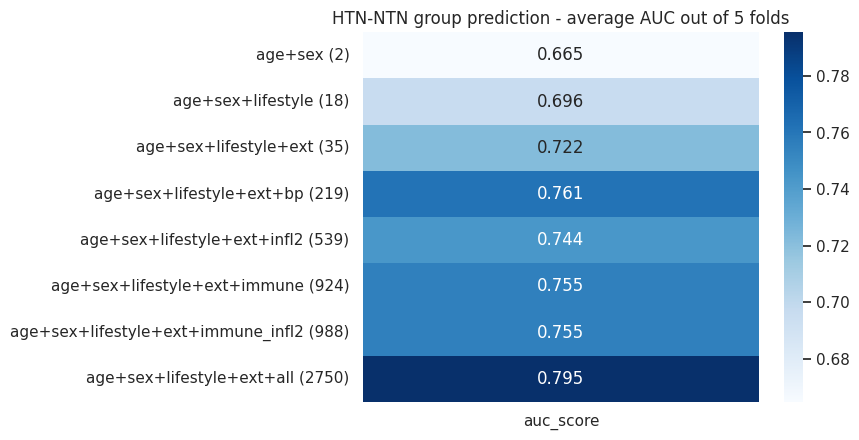

In [58]:
sns.heatmap(data=results_aucs, annot=True, fmt=".3f", cmap="Blues")
plt.title("HTN-NTN group prediction - average AUC out of 5 folds")
plt.show()

In [5]:
from biobank_olink.constants import PROJECT_DATA

years = 10

two_ex_df = pd.read_csv(
    PROJECT_DATA / "feat_importances" / "two_extremes_xgb_corr0.9_sbp_th0.35.csv", index_col=0)

In [6]:
feat_imps = results.loc[
    (results[["lifestyle", "ext", "olink"]].all(axis=1))
    &
    (results["years"] == years)
    ].shap_importance
feat_imps = pd.DataFrame(list(feat_imps.values)).T.sort_values(0, ascending=False)
feat_imps = feat_imps.rank(ascending=False).mean(axis=1).sort_values(ascending=True)
feat_imps.name = "pred_diag_imp"
feat_imps = feat_imps.to_frame()

In [7]:
feat_imps2 = feat_imps.merge(two_ex_df, left_index=True, right_index=True, how="left")
feat_imps2.rename(columns={"shap_importance_rank": "two_extremes_sbp_imps"}, inplace=True)
feat_imps2[["pred_diag_imp", "two_extremes_sbp_imps", "panel"]]

,pred_diag_imp,two_extremes_sbp_imps,panel
age,1.0,NaN,NaN
REN,2.0,1.0,"['cardiometabolic', 'bp', 'renal']"
GDF15,3.2,508.4,['cardiometabolic']
HAVCR1,4.0,46.0,"['oncology', 'immune', 'imn_inf2']"
ADM,6.2,984.4,"['oncology', 'infl2', 'bp', 'renal', 'imn_inf2']"
...,...,...,...
alcohol_1.0,2471.1,NaN,NaN
smoking_2.0,2471.1,NaN,NaN
physactivity_2.0,2471.1,NaN,NaN
alcohol_6.0,2471.1,NaN,NaN
